<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS767/blob/main/CS767_Assignment7_Gupta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf
import numpy as np
import math
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras.datasets import cifar10
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# load cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
# random seed
InitSeed = 767
tf.random.set_seed(InitSeed)
np.random.seed( InitSeed)

In [ ]:
#standardize images one by one
x_train = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), x_train, dtype=tf.float32).numpy()

In [ ]:
#standardize images one by one
x_test = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), x_test, dtype=tf.float32).numpy()

# split train and validation sets using stratified datasets

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [ ]:
# learning rate scheduler - #1
def step_decay1(epoch):
   initial_lrate = 0.001
   drop = 0.0001
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate1 = tf.keras.callbacks.LearningRateScheduler(step_decay1)

# learning rate scheduler - #2
# Observed that this learning rate scheduler turned out to be very useful in achieveing a good validation accuracy

In [ ]:
def step_decay2(epoch, lr):
     return lr * tf.math.exp(-0.1)

lrate2 = tf.keras.callbacks.LearningRateScheduler(step_decay2)

# MLP with total five layers, RelU activation function and callbacks (early stopping, ModelCheckpoint(save the best model) and Learning rate scheduler)
# Batch size - 128
# Increased the patience of EarlyStopping callback to 20
# Using val_accuracy as the monitor for ModelCheckpoint

In [ ]:
# callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint ("my_cifar10.model.h5" , save_best_only=True,monitor='val_accuracy')
earlystopping_cb = keras.callbacks.EarlyStopping (patience=20, restore_best_weights=True)

# epochs = 50
# learning_rate = 0.001
# decay_rate = learning_rate / epochs
# momentum = 0.8

# Model
input1 = keras.layers.Flatten(input_shape=[32,32,3])
hidden1 = keras.layers.Dense(2048, activation='relu', name="Hidden1")
hidden2 = keras.layers.Dense(1024, activation='relu', name="Hidden2")
hidden3 = keras.layers.Dense(512, activation='relu', name="Hidden3")
output = keras.layers.Dense(10, activation='softmax', name="Output")

model1 = keras.models.Sequential([input1, hidden1, hidden2, hidden3, output])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

print(model1.summary())

hist1 = model1.fit(x_train, y_train,epochs=100, batch_size=128, validation_data=(x_valid, y_valid), verbose=2, callbacks=[earlystopping_cb, checkpoint_cb, lrate2])

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 3072)              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
Hidden2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
Hidden3 (Dense)              (None, 512)               524800    
_________________________________________________________________
Output (Dense)               (None, 10)                5130      
Total params: 8,921,610
Trainable params: 8,921,610
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
352/352 - 28s - loss: 1.6805 - accuracy: 0.4095 - val_loss: 1.5134 - val_accuracy: 0.4566
Ep

# Model produced a validation accuracy of 56.45%
# Even though validation accuracy was improving, validation loss continued to deteriorate after a certain epoch, pointing to the fact that model started to overfit from their onwards. 

313/313 - 3s - loss: 230.1946 - accuracy: 0.4732

 Test accuracy: 0.4731999933719635


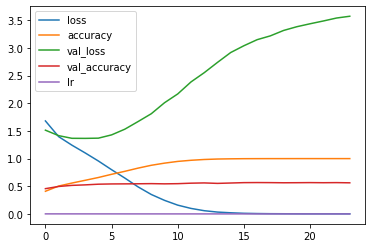

In [ ]:
# Evaluate the model
df = pd.DataFrame(hist1.history)
plt.plot(df)
plt.legend(df.columns)

model = keras.models.load_model('my_cifar10.model-validation-accuracy56.54.h5')
score = model.evaluate(x_test, y_test, verbose=2)
print('\n', 'Test accuracy:', score[1])

# Model produced a Test accuracy of 47.3%

In [ ]:
# class MyCallback(tf.keras.callbacks.Callback):
#     def get_config(self):
#         cfg = super().get_config()
#         return cfg  
#     def on_epoch_end(self, epoch, logs=None):
#         self.model.save('model.h5')

# MLP with total five layers(input,3 hidden layers and output), RelU activation function and callbacks (early stopping, ModelCheckpoint(save the best model) and Learning rate scheduler).
# Also added BatchNormalization layer after each hidden layer with activation functions
# Using ModelCheckPoint callback, I could only save weights as saving other parameters errored out (Seems that it needed me to override get_config during initialization to load the right weights again)

In [ ]:
# Include Batch Normalization 
# ModelCheckPoint only save the weights
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10.model_weights.h5", save_best_only=True,monitor='val_accuracy', save_weights_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping (patience=20, restore_best_weights=True)

input1 = keras.layers.Flatten(input_shape=[32,32,3])
hidden1 = keras.layers.Dense(2048, activation='relu', name="Hidden1")
batch_normalization1 = tf.keras.layers.BatchNormalization()
hidden2 = keras.layers.Dense(1024, activation='relu', name="Hidden2")
batch_normalization2 = tf.keras.layers.BatchNormalization()
hidden3 = keras.layers.Dense(512, activation='relu', name="Hidden3")
batch_normalization3 = tf.keras.layers.BatchNormalization()
output = keras.layers.Dense(10, activation='softmax', name="Output")

model1 = keras.models.Sequential([input1, hidden1,batch_normalization1 , hidden2,batch_normalization2, hidden3, batch_normalization3, output])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model1.optimizer.learning_rate)
hist1 = model1.fit(x_train, y_train,epochs=100, batch_size=128, validation_data=(x_valid, y_valid), verbose=2, callbacks=[earlystopping_cb,checkpoint_cb, lrate2])

df = pd.DataFrame(hist1.history)
plt.plot(df)
plt.legend(df.columns)

model1.load_weights('my_cifar10.model_weights.h5')
score = model.evaluate(x_test, y_test, verbose=2)
print('\n', 'Test accuracy:', score[1])


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
Epoch 1/100
352/352 - 31s - loss: 1.6957 - accuracy: 0.4069 - val_loss: 1.5615 - val_accuracy: 0.4650
Epoch 2/100
352/352 - 29s - loss: 1.3918 - accuracy: 0.5066 - val_loss: 1.4746 - val_accuracy: 0.4750
Epoch 3/100
352/352 - 29s - loss: 1.2360 - accuracy: 0.5657 - val_loss: 1.3922 - val_accuracy: 0.5122
Epoch 4/100
352/352 - 33s - loss: 1.0913 - accuracy: 0.6156 - val_loss: 1.3694 - val_accuracy: 0.5262
Epoch 5/100
352/352 - 31s - loss: 0.9437 - accuracy: 0.6667 - val_loss: 1.4050 - val_accuracy: 0.5358
Epoch 6/100
352/352 - 31s - loss: 0.7964 - accuracy: 0.7191 - val_loss: 1.3918 - val_accuracy: 0.5452
Epoch 7/100
352/352 - 30s - loss: 0.6390 - accuracy: 0.7756 - val_loss: 1.5651 - val_accuracy: 0.5272
Epoch 8/100
352/352 - 31s - loss: 0.4867 - accuracy: 0.8300 - val_loss: 1.5999 - val_accuracy: 0.5482
Epoch 9/100
352/352 - 29s - loss: 0.3454 - accuracy: 0.8836 - val_loss: 1.7695 - val_accuracy: 0.5552
Epoch 10/100
3

# Adding Batch normalization in first two hidden layers improved the validation accuracy to 58.3%

# MLP with total five layers(input,3 hidden layers and output), hyperbolic tangent (tanh) activation function and callbacks (early stopping, ModelCheckpoint(save the best model) and Learning rate scheduler).

In [ ]:
# Using Tanh activation function
checkpoint_cb = keras.callbacks.ModelCheckpoint ("my_cifar10.model.h5" , save_best_only=True,monitor='val_accuracy')
earlystopping_cb = keras.callbacks.EarlyStopping (patience=20, restore_best_weights=True)

input1 = keras.layers.Flatten(input_shape=[32,32,3])
hidden1 = keras.layers.Dense(2048, activation='tanh', name="Hidden1")
hidden2 = keras.layers.Dense(1024, activation='tanh', name="Hidden2")
hidden3 = keras.layers.Dense(512, activation='tanh', name="Hidden3")
output = keras.layers.Dense(10, activation='softmax', name="Output")

model1 = keras.models.Sequential([input1, hidden1, hidden2, hidden3, output])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model1.optimizer.learning_rate)
hist1 = model1.fit(x_train, y_train,epochs=100, batch_size=128, validation_data=(x_valid, y_valid), verbose=2, callbacks=[earlystopping_cb, checkpoint_cb, lrate2])

df = pd.DataFrame(hist1.history)
plt.plot(df)
plt.legend(df.columns)

model = keras.models.load_model('my_cifar10.model.h5')
score = model.evaluate(x_test, y_test, verbose=2)
print('\n', 'Test accuracy:', score[1])


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
Epoch 1/100
352/352 - 30s - loss: 1.9047 - accuracy: 0.3483 - val_loss: 1.7624 - val_accuracy: 0.3910
Epoch 2/100
352/352 - 27s - loss: 1.6736 - accuracy: 0.4242 - val_loss: 1.6726 - val_accuracy: 0.4220
Epoch 3/100
352/352 - 29s - loss: 1.5760 - accuracy: 0.4571 - val_loss: 1.5984 - val_accuracy: 0.4512
Epoch 4/100
352/352 - 31s - loss: 1.4614 - accuracy: 0.4979 - val_loss: 1.5814 - val_accuracy: 0.4550
Epoch 5/100
352/352 - 29s - loss: 1.3604 - accuracy: 0.5317 - val_loss: 1.5588 - val_accuracy: 0.4678
Epoch 6/100
352/352 - 29s - loss: 1.2482 - accuracy: 0.5719 - val_loss: 1.5682 - val_accuracy: 0.4644
Epoch 7/100
352/352 - 28s - loss: 1.1227 - accuracy: 0.6167 - val_loss: 1.5843 - val_accuracy: 0.4716
Epoch 8/100
352/352 - 27s - loss: 0.9803 - accuracy: 0.6702 - val_loss: 1.6200 - val_accuracy: 0.4764
Epoch 9/100
352/352 - 27s - loss: 0.8234 - accuracy: 0.7261 - val_loss: 1.6456 - val_accuracy: 0.4874
Epoch 10/100
3

## Using hyperbolic tangent function did not improve the validation accuracy which was capped at 48.74, even though training accuracy easily reached to optimal 1.

# MLP with total five layers(input,3 hidden layers and output), Sigmoid activation function and callbacks (early stopping, ModelCheckpoint(save the best model) and Learning rate scheduler).

In [ ]:
# Using sigmoid activation function
checkpoint_cb = keras.callbacks.ModelCheckpoint ("my_cifar10.model.h5" , save_best_only=True,monitor='val_accuracy')
earlystopping_cb = keras.callbacks.EarlyStopping (patience=20, restore_best_weights=True)

input1 = keras.layers.Flatten(input_shape=[32,32,3])
hidden1 = keras.layers.Dense(2048, activation='sigmoid', name="Hidden1")
hidden2 = keras.layers.Dense(1024, activation='sigmoid', name="Hidden2")
hidden3 = keras.layers.Dense(512, activation='sigmoid', name="Hidden3")
output = keras.layers.Dense(10, activation='softmax', name="Output")

model1 = keras.models.Sequential([input1, hidden1, hidden2, hidden3, output])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model1.optimizer.learning_rate)
hist1 = model1.fit(x_train, y_train,epochs=100, batch_size=128, validation_data=(x_valid, y_valid), verbose=2, callbacks=[earlystopping_cb, checkpoint_cb, lrate2])

df = pd.DataFrame(hist1.history)
plt.plot(df)
plt.legend(df.columns)

model = keras.models.load_model('my_cifar10.model.h5')
score = model.evaluate(x_test, y_test, verbose=2)
print('\n', 'Test accuracy:', score[1])


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
Epoch 1/100
352/352 - 32s - loss: 1.7353 - accuracy: 0.3781 - val_loss: 1.5619 - val_accuracy: 0.4468
Epoch 2/100
352/352 - 28s - loss: 1.4750 - accuracy: 0.4766 - val_loss: 1.4713 - val_accuracy: 0.4818
Epoch 3/100
352/352 - 29s - loss: 1.3332 - accuracy: 0.5301 - val_loss: 1.4100 - val_accuracy: 0.5016
Epoch 4/100
352/352 - 34s - loss: 1.2004 - accuracy: 0.5773 - val_loss: 1.4183 - val_accuracy: 0.5032
Epoch 5/100
352/352 - 31s - loss: 1.0583 - accuracy: 0.6254 - val_loss: 1.4078 - val_accuracy: 0.5132
Epoch 6/100
352/352 - 31s - loss: 0.8875 - accuracy: 0.6906 - val_loss: 1.4363 - val_accuracy: 0.5258
Epoch 7/100
352/352 - 27s - loss: 0.7052 - accuracy: 0.7543 - val_loss: 1.6025 - val_accuracy: 0.5044
Epoch 8/100
352/352 - 29s - loss: 0.5362 - accuracy: 0.8171 - val_loss: 1.6412 - val_accuracy: 0.5286
Epoch 9/100
352/352 - 29s - loss: 0.3721 - accuracy: 0.8776 - val_loss: 1.8267 - val_accuracy: 0.5118
Epoch 10/100
3

## Using Sigmoid function, did not improve the validation accuracy which was capped at around 53% mark, even though training accuracy easily reached to optimal 1.